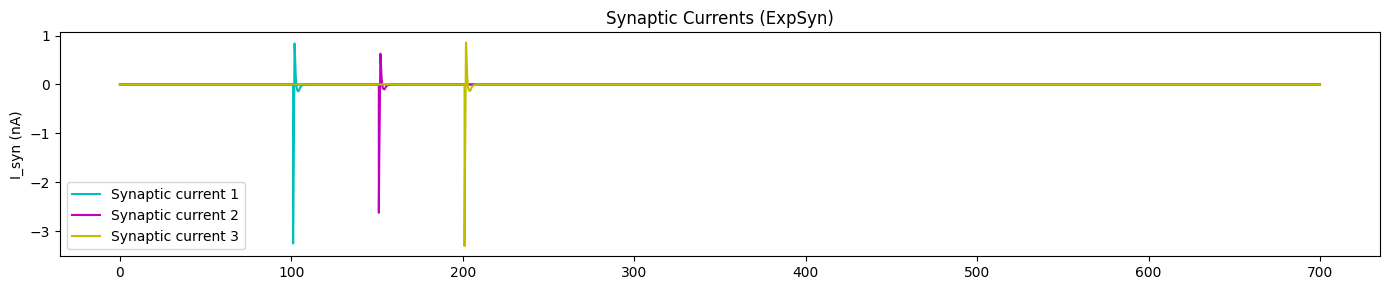

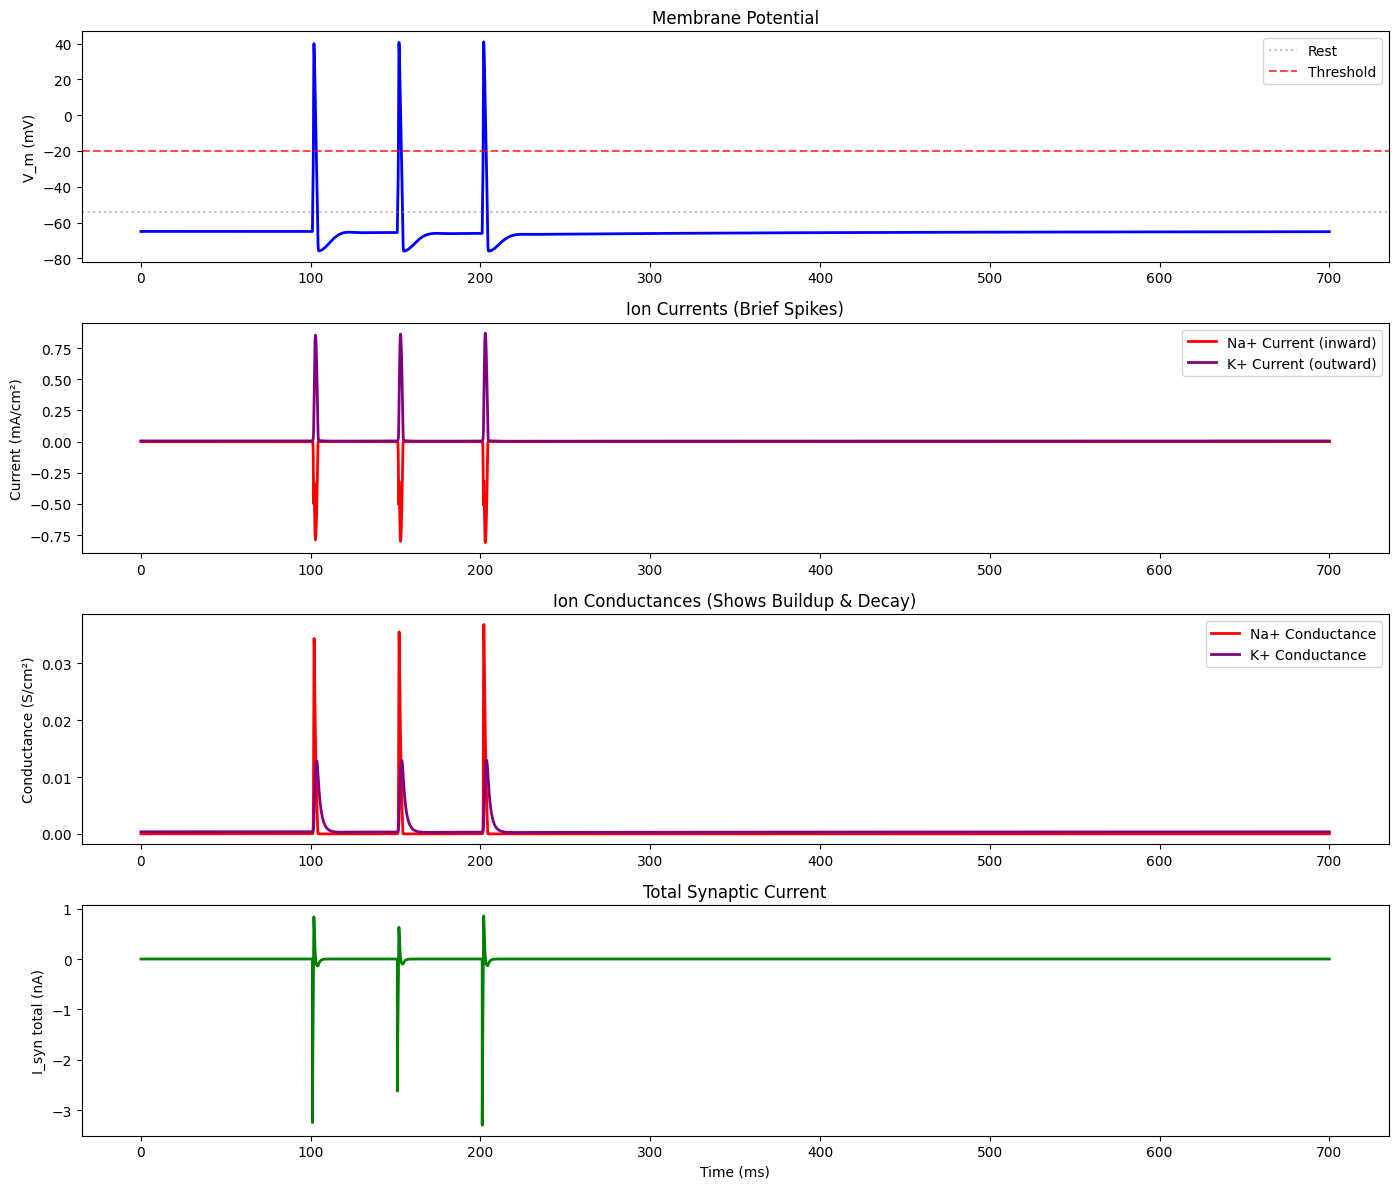

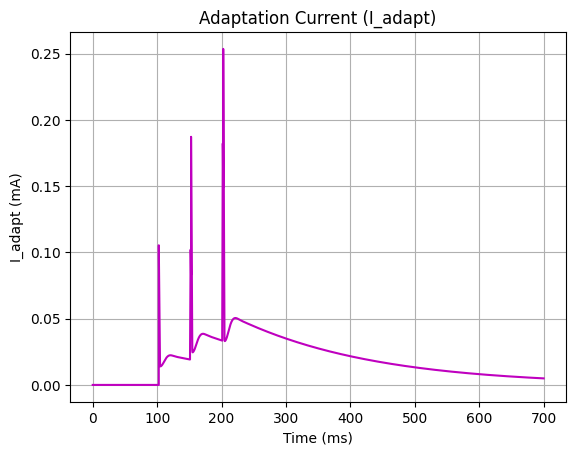

Number of spikes: 3
Max Na+ conductance: 0.0368 S/cm²
Max K+ conductance: 0.0130 S/cm²
K+ conductance at end: 0.0004 S/cm² (should be elevated)


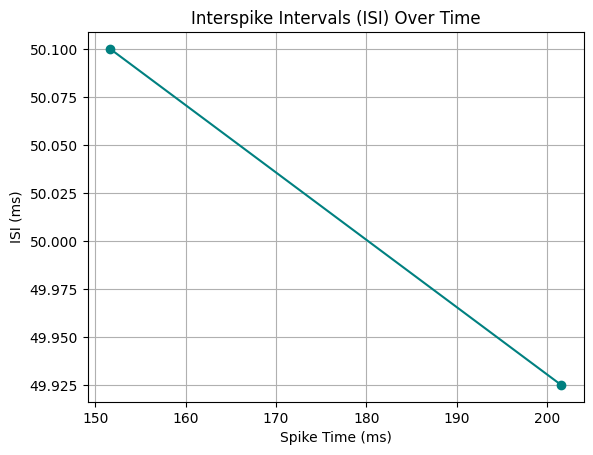

Mean ISI: 50.01 ms
First ISI: 50.10 ms
Last ISI: 49.92 ms
ISI increase: -0.18 ms


In [17]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.12   # Standard Na+ conductance
    seg.hh.gkbar = 0.036   # Standard K+ conductance
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -54.3      # Leak reversal potential


# Adaptation mechanism (POINT_PROCESS)
adapt_mech = h.Adapt(soma(0.5))
adapt_mech.gmax = 0.001  # Max conductance (S) — adjust for stronger/weaker adaptation
adapt_mech.tau = 200     # Decay time constant (ms) — higher = slower decay

# Current injection
# First input current
#stim1 = h.IClamp(soma(0.5))
#stim1.delay = 100
#stim1.dur = 200
#stim1.amp = 1.0

# Second input current — starts while first is still ongoing
#stim2 = h.IClamp(soma(0.5))
#stim2.delay = 250
#stim2.dur = 200
#stim2.amp = 0.5

#stim3 = h.IClamp(soma(0.5))
#stim3.delay = 400
#stim3.dur = 150
#stim3.amp = 0.8

# Synaptic input (ExpSyn synapses)
syn1 = h.ExpSyn(soma(0.5))
syn2 = h.ExpSyn(soma(0.5))
syn3 = h.ExpSyn(soma(0.5))

# Set reversal potentials for excitatory input (0 mV by default)
syn1.e = 0
syn2.e = 0
syn3.e = 0

# Set decay time constants (ms). You can adjust for "faster" or "slower" synapses for postsynaptic time constant
syn1.tau = 1 #all of these values must be the same because they refer to the post synaptic neuron for all synapses to the post synaptic neuron
syn2.tau = 1
syn3.tau = 1

# NetStim objects to generate presynaptic "spikes" (events)
stim1 = h.NetStim()
stim1.start = 100   # ms
stim1.number = 1
stim1.interval = 1  # Ignored when number=1

stim2 = h.NetStim()
stim2.start = 150   # ms
stim2.number = 1
stim2.interval = 1

stim3 = h.NetStim()
stim3.start = 200   # ms
stim3.number = 1
stim3.interval = 1

# NetCon objects, connect each NetStim to synapse, set weight for each input (unit: uS)
nc1 = h.NetCon(stim1, syn1)
nc1.weight[0] = 0.05  # "weight": synaptic strength for input 1 (adjust as desired)
nc2 = h.NetCon(stim2, syn2)
nc2.weight[0] = 0.04  # weight for input 2
nc3 = h.NetCon(stim3, syn3)
nc3.weight[0] = 0.05 # weight for input 3

# Optionally, you can make NetStim fire >1 spike by setting .number > 1 and adjusting .interval



# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection and recording
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)
# Trigger adaptation mechanism with spike threshold
adapt_nc = h.NetCon(soma(0.5)._ref_v, adapt_mech, sec=soma)
adapt_nc.threshold = -20
adapt_nc.weight[0] = 1  # Strength of adaptation trigger per spike


# NEW: Record gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)  # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)  # K+ activation
iadapt = h.Vector().record(adapt_mech._ref_iadapt)
isyn1 = h.Vector().record(syn1._ref_i)
isyn2 = h.Vector().record(syn2._ref_i)
isyn3 = h.Vector().record(syn3._ref_i)

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
iadapt = np.array(iadapt)
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)
isyn1 = np.array(isyn1)
isyn2 = np.array(isyn2)
isyn3 = np.array(isyn3)

# Add a subplot for synaptic currents:
plt.figure(figsize=(14, 3))
plt.plot(t, isyn1, 'c', label='Synaptic current 1')
plt.plot(t, isyn2, 'm', label='Synaptic current 2')
plt.plot(t, isyn3, 'y', label='Synaptic current 3')
plt.ylabel('I_syn (nA)')
plt.title('Synaptic Currents (ExpSyn)')
plt.legend()
plt.tight_layout()
plt.show()


# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance


# Plotting
plt.figure(figsize=(14, 12))

# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')

# Ion CURRENTS (what you were plotting before)
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents (Brief Spikes)')

# Ion CONDUCTANCES (what you want to see)
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances (Shows Buildup & Decay)')

# Calculate and plot total synaptic current (optional, replaces input_current)
isyn_total = isyn1 + isyn2 + isyn3

plt.subplot(4, 1, 4)
plt.plot(t, isyn_total, 'g', linewidth=2)
plt.ylabel('I_syn total (nA)')
plt.xlabel('Time (ms)')
plt.title('Total Synaptic Current')


plt.tight_layout()
plt.show()
plt.figure()
plt.plot(t, iadapt, 'm')
plt.title('Adaptation Current (I_adapt)')
plt.xlabel('Time (ms)')
plt.ylabel('I_adapt (mA)')
plt.grid(True)
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")

# Calculate ISIs (Interspike Intervals)
if len(spikes) > 1:
    isis = np.diff(spikes)
    plt.figure()
    plt.plot(spikes[1:], isis, marker='o', linestyle='-', color='teal')
    plt.title('Interspike Intervals (ISI) Over Time')
    plt.xlabel('Spike Time (ms)')
    plt.ylabel('ISI (ms)')
    plt.grid(True)
    plt.show()

    print(f"Mean ISI: {np.mean(isis):.2f} ms")
    print(f"First ISI: {isis[0]:.2f} ms")
    print(f"Last ISI: {isis[-1]:.2f} ms")
    print(f"ISI increase: {isis[-1] - isis[0]:.2f} ms")
else:
    print("Not enough spikes to compute ISIs.")



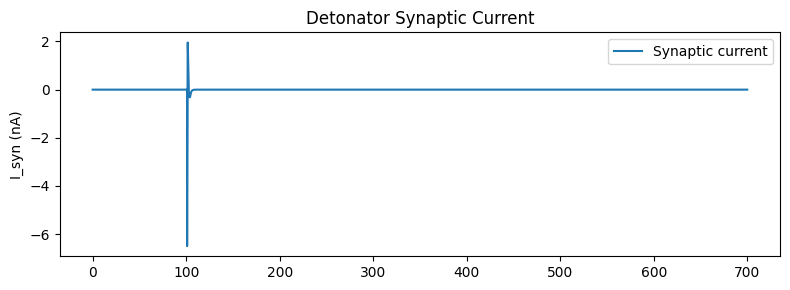

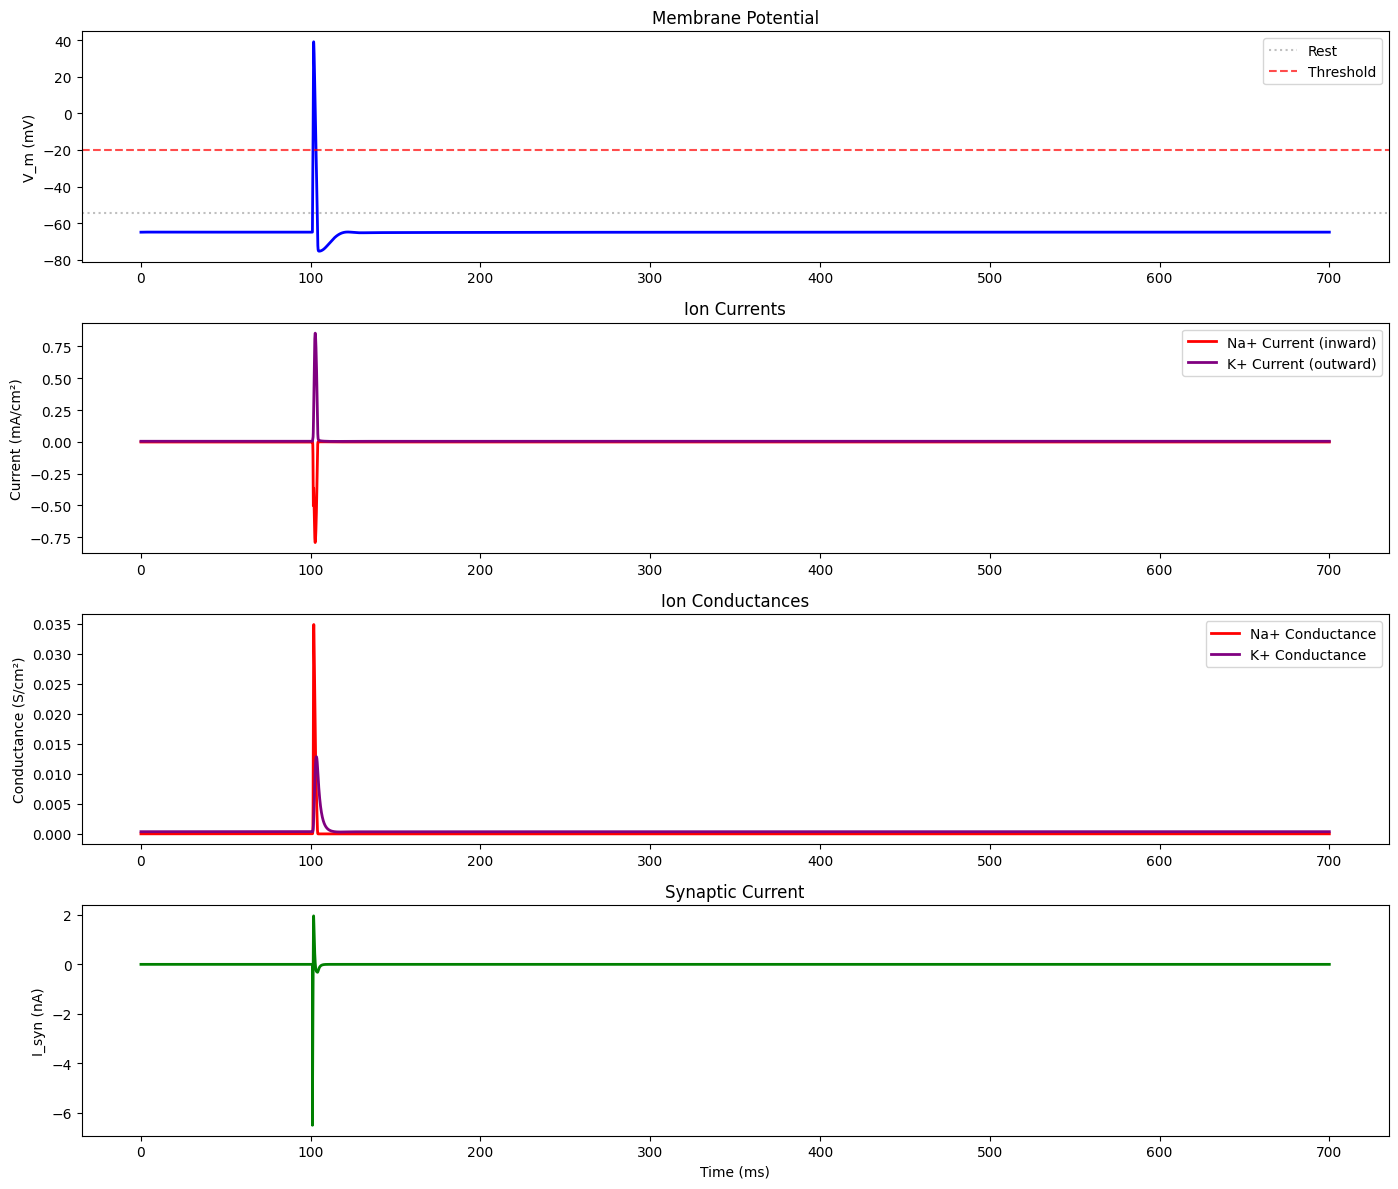

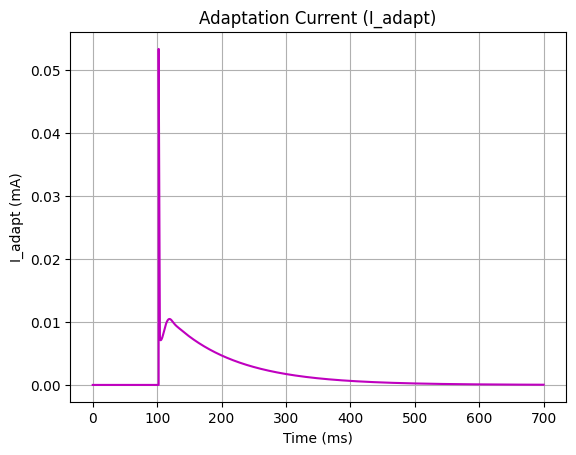

Number of spikes: 1
Spike times: [101.35] ms
Max Na+ conductance: 0.0349 S/cm²
Max K+ conductance: 0.0129 S/cm²
K+ conductance at end: 0.0004 S/cm² (should be elevated)
Not enough spikes to compute ISIs.


In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.12   # Standard Na+ conductance
    seg.hh.gkbar = 0.036   # Standard K+ conductance
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -54.3      # Leak reversal potential

# Adaptation mechanism (POINT_PROCESS)
adapt_mech = h.Adapt(soma(0.5))
adapt_mech.gmax = 0.0005  # Lower for quicker spike suppression, promoting single-spike behavior
adapt_mech.tau = 100      # Decay time constant (ms)

# Detonator synaptic input (single strong synapse)
syn = h.ExpSyn(soma(0.5))
syn.e = 0
syn.tau = 1    # Fast synapse for brief, strong EPSC

stim = h.NetStim()
stim.start = 100   # ms
stim.number = 1    # Single presynaptic event
stim.interval = 1

nc = h.NetCon(stim, syn)
nc.weight[0] = 0.1   # Strong synaptic weight (uS); adjust if necessary

# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)
isyn = h.Vector().record(syn._ref_i)
iadapt = h.Vector().record(adapt_mech._ref_iadapt)

# Spike detection and recording
spike_times = h.Vector()
nc_th = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc_th.threshold = -20
nc_th.record(spike_times)
# Adaptation trigger
adapt_nc = h.NetCon(soma(0.5)._ref_v, adapt_mech, sec=soma)
adapt_nc.threshold = -20
adapt_nc.weight[0] = 1

# NEW: Record HH gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)    # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)       # K+ activation

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
iadapt = np.array(iadapt)
isyn = np.array(isyn)
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)

# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance

# Plot synaptic (detonator) current
plt.figure(figsize=(8, 3))
plt.plot(t, isyn, label='Synaptic current')
plt.ylabel('I_syn (nA)')
plt.title('Detonator Synaptic Current')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting all results
plt.figure(figsize=(14, 12))
# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')
# Ion CURRENTS
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents')
# Ion CONDUCTANCES
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances')
# Synaptic current
plt.subplot(4, 1, 4)
plt.plot(t, isyn, 'g', linewidth=2)
plt.ylabel('I_syn (nA)')
plt.xlabel('Time (ms)')
plt.title('Synaptic Current')
plt.tight_layout()
plt.show()
# Adaptation current
plt.figure()
plt.plot(t, iadapt, 'm')
plt.title('Adaptation Current (I_adapt)')
plt.xlabel('Time (ms)')
plt.ylabel('I_adapt (mA)')
plt.grid(True)
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Spike times: {spikes} ms")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")

# Calculate and plot ISIs (should only have one spike)
if len(spikes) > 1:
    isis = np.diff(spikes)
    plt.figure()
    plt.plot(spikes[1:], isis, marker='o', linestyle='-', color='teal')
    plt.title('Interspike Intervals (ISI) Over Time')
    plt.xlabel('Spike Time (ms)')
    plt.ylabel('ISI (ms)')
    plt.grid(True)
    plt.show()
    print(f"Mean ISI: {np.mean(isis):.2f} ms")
else:
    print("Not enough spikes to compute ISIs.")
